In [20]:
%load_ext autoreload
%autoreload 2
    
import os, sys
PWD = os.getenv('PWD')

PROJ_MISSING_MSG = """Set an enviroment variable:\n
`DJANGO_PROJECT=your_project_name`\n
or call:\n
`init_django(your_project_name)`
"""

def init_django(project_name=None):
    os.chdir(PWD)
    project_name = project_name or os.environ.get('DJANGO_PROJECT') or None
    if project_name == None:
        raise Exception(PROJ_MISSING_MSG)
    sys.path.insert(0, os.getenv('PWD'))
    os.environ.setdefault('DJANGO_SETTINGS_MODULE', f'{project_name}.settings')
    os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
    import django
    django.setup()

init_django("server")
import numpy as np
import os
from matplotlib import pyplot as plt
import functools
import math
import cv2
import copy
from skimage.measure import regionprops
from scipy import spatial
import pickle
from alignment.other_utils import get_matches
from alignment.prepare_images import get_scaled_sem, process_im_file
from alignment.mask_utils import get_masks, filter_objects
from alignment.file_utils import initialize, set_mims_dir, save_data, load_data, load_image
from alignment.rough_alignment import find_overlapping, manipulate_mask
from alignment.fine_alignment import get_final_location_and_angle
from registration.models import RegistrationProject, ImageRegistration
from alignment.make_final_masks import get_boundaries, show_anns, adjust_to_dims
from alignment.file_utils import save_image, save_figure
from matplotlib.figure import Figure


def calculate_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score


def slide_and_find_max_overlap(large_mask, small_mask):
    max_iou = 0
    best_position = (0, 0)

    for y in range(0, large_mask.shape[0] - small_mask.shape[0], 2):
        for x in range(0, large_mask.shape[1] - small_mask.shape[1], 2):
            large_submask = large_mask[
                y : y + small_mask.shape[0], x : x + small_mask.shape[1]
            ]
            iou = calculate_iou(large_submask, small_mask)

            if iou > max_iou:
                max_iou = iou
                best_position = (y, x)

    return max_iou, best_position
    
def furthest_pts_distance(array):
    # convex hull ops
    props = regionprops(array)
    return props[0].feret_diameter_max

def first_nonzero(arr, axis=0, invalid_val=0):
    mask = arr!=0
    return np.where(mask.any(axis=axis), mask.argmax(axis=axis), invalid_val)
def last_nonzero(arr, axis=0, invalid_val=0):
    mask = arr!=0
    val = arr.shape[axis] - np.flip(mask, axis=axis).argmax(axis=axis) - 1
    return np.where(mask.any(axis=axis), val, invalid_val)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
mims = ImageRegistration.objects.get(id=331)
context = initialize(mims.project, mims)
mims_masks = load_image(context, "mims_mask_raw.tiff")
mims_masks = mims_masks.astype(np.uint8) * 255
mims_masks ^= 255
sem_masks = load_image(context, "sem_mask_raw.tiff")
sem_masks = sem_masks.astype(np.uint8) * 255
sem_masks ^= 255
data = load_data(context, "final_data")
original_sem_lims = data["scaled_sem_lims"]
flip = data["flip"]
segmentation_angle = data["angle"]

mims_dist = furthest_pts_distance(mims_masks)
sem_dist = furthest_pts_distance(sem_masks)
scaling_adjustment = sem_dist/mims_dist

new_sem_dims = [round(p/scaling_adjustment) for p in sem_masks.shape]
sem_masks_adjusted = cv2.resize(sem_masks, new_sem_dims, interpolation=cv2.INTER_NEAREST)

# Make the mask like the original SEM, flip it back and adjust angle
fake_ = {}
fake_["original_segmentation"] = sem_masks_adjusted
sem_masks_adjusted_unrotated = manipulate_mask(fake_, angle=-segmentation_angle, flip=flip, full_image=True)[
    "segmentation"
]

485.11545017655334 484.7525141760484


In [3]:
# Now test for best fine alignment of the sem and mims masks
fake_["original_segmentation"] = sem_masks_adjusted_unrotated

best_iou = 0
best_angle = 0
for angle in np.linspace(segmentation_angle-5, segmentation_angle+5, 11):
    sem_masks_rotated = manipulate_mask(fake_, flip2=flip, angle=angle, full_image=True)[
        "segmentation"
    ]
    (pos_iou, pos_position) = slide_and_find_max_overlap(
        sem_masks_rotated, mims_masks
    )
    if pos_iou > best_iou:
        best_iou = pos_iou
        best_angle = angle
sem_masks_rotated = manipulate_mask(fake_, flip2=flip, angle=best_angle, full_image=True)[
    "segmentation"
]

18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0


In [68]:
# Find location in a freshly scaled sem context
import time
start = time.time()

# Get the original SEM mask rotation
scaled_sem = get_scaled_sem(context)
fake_["original_segmentation"] = scaled_sem
scaled_sem = manipulate_mask(fake_, angle=-segmentation_angle, flip2=flip, full_image=True)["segmentation"]
scaled_sem_masks = np.full(scaled_sem.shape, 0, np.uint8)
scaled_sem_masks[original_sem_lims[0] : original_sem_lims[1], original_sem_lims[2] : original_sem_lims[3]] = sem_masks

new_dims = [round(scaled_sem.shape[1]/scaling_adjustment), round(scaled_sem.shape[0]/scaling_adjustment)]
scaled_sem = cv2.resize(scaled_sem, new_dims, interpolation=cv2.INTER_NEAREST)
scaled_sem_masks = cv2.resize(scaled_sem_masks, new_dims, interpolation=cv2.INTER_NEAREST)

def get_lims(array):
    return [first_nonzero(first_nonzero(array, 1)), last_nonzero(last_nonzero(array, 1)), 
        first_nonzero(first_nonzero(array, 0)), last_nonzero(last_nonzero(array, 0))]
    
def adjust_sem(sem_image, first_angle, second_angle, flip):
    fake_["original_segmentation"] = sem_image
    # reverse the first angle manipulation
    adjusted = manipulate_mask(
        fake_, angle=first_angle, flip=flip, full_image=True
    )["segmentation"]
    # Do the forward manipulation
    fake_["original_segmentation"] = adjusted
    adjusted = manipulate_mask(
        fake_, angle=second_angle, flip2=flip, full_image=True
    )["segmentation"]
    return adjusted

# Then undo the rotation and redo it with the new best angle and scaling
scaled_sem_masks = adjust_sem(scaled_sem_masks, segmentation_angle, -best_angle, flip)

# Get some bounds to make this faster
mims_lims = get_lims(mims_masks)
sem_lims = get_lims(scaled_sem_masks)
mims_xmin = first_nonzero(first_nonzero(mims_masks, 0))
mims_xmax = last_nonzero(last_nonzero(mims_masks, 0))
mims_ymin = first_nonzero(first_nonzero(mims_masks, 1))
mims_ymax = last_nonzero(last_nonzero(mims_masks, 1))
sem_xmin = first_nonzero(first_nonzero(scaled_sem_masks, 0))
sem_xmax = last_nonzero(last_nonzero(scaled_sem_masks, 0))
sem_ymin = first_nonzero(first_nonzero(scaled_sem_masks, 1))
sem_ymax = last_nonzero(last_nonzero(scaled_sem_masks, 1))
sem_xstart = sem_xmin - mims_xmin - 50
sem_xend = sem_xmax + 50
sem_ystart = sem_ymin - mims_ymin - 50
sem_yend = sem_ymax + 50

(pos_iou, best_position) = slide_and_find_max_overlap(
    scaled_sem_masks[sem_ystart:sem_yend, sem_xstart:sem_xend], mims_masks
)
best_position = [best_position[0] + sem_ystart, best_position[1] + sem_xstart]


scaled_sem_mask_crop = scaled_sem_masks[
    best_position[0] : best_position[0] + mims_masks.shape[0],
    best_position[1] : best_position[1] + mims_masks.shape[1],
]
print(best_position, pos_iou)
print(scaled_sem_masks.shape)


[1671, 2162] 0.6130873121552216
(5044, 4907)


255


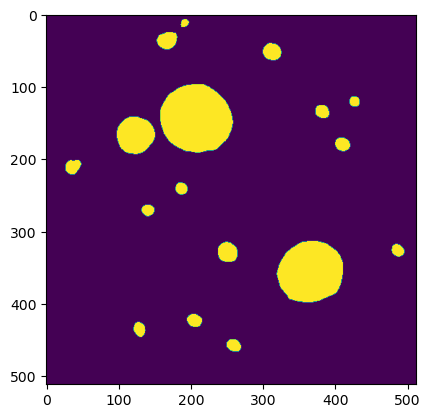

In [69]:
from matplotlib import pyplot as plt
pltname = f"{str(context.mims.id)}"
plt.imshow(mims_masks)
print(np.max(mims_masks))
save_image(context, scaled_sem_mask_crop, f"{pltname}_sem_masks_position")

In [70]:
import cv2
from alignment.prepare_images import get_mims_pixel_size
sem_pixel_size = 5
mims_pixel_size = get_mims_pixel_size(context.mims.mims_image)
pixel_scaling = mims_pixel_size / sem_pixel_size
pixel_scaling = pixel_scaling / scaling_adjustment

width = int(mims_masks.shape[1] * pixel_scaling)
height = int(mims_masks.shape[0] * pixel_scaling)
dim = (width, height)
fullsize_sem_position = [round(p * pixel_scaling) for p in best_position]
post_segmentation_data = {
    "angle": best_angle,
    "flip": flip,
    "pixel_scaling": pixel_scaling,
    "fullsize_sem_position": fullsize_sem_position,
    "iou": pos_iou,
}
mims_masks_big = cv2.resize(
    mims_masks, dim, interpolation=cv2.INTER_NEAREST
)
save_image(context, mims_masks_big, f"{pltname}_fullsize_mims_masks_raw")

In [71]:
from alignment.prepare_images import get_fullsize_sem
fullsize_sem = get_fullsize_sem(context)
fake_["original_segmentation"] = fullsize_sem


In [66]:
# Do the same set of manipulations to ensure the same size...TODO: make this better
fullsize_sem = manipulate_mask(fake_, angle=-segmentation_angle, flip=flip, full_image=True)[
    "segmentation"
]
fullsize_sem_crop = fullsize_sem2[
    fullsize_sem_position[0] : fullsize_sem_position[0] + mims_masks_big.shape[0],
    fullsize_sem_position[1] : fullsize_sem_position[1] + mims_masks_big.shape[1],
]
save_image(context, fullsize_sem2, f"{pltname}_fullsize_sem")
save_image(context, fullsize_sem_crop, f"{pltname}_fullsize_sem_crop")

In [22]:
print([p*pixel_scaling for p in scaled_sem_masks.shape])


[38641.00189001483, 34560.8171509705]


<Figure size 1000x1000 with 0 Axes>

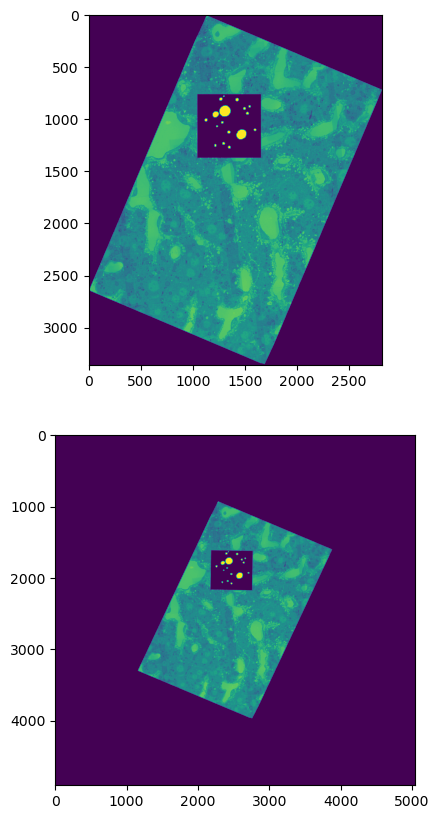

In [10]:
plt.figure(figsize=(10,10))

#subplot(r,c) provide the no. of rows and columns
f, ax = plt.subplots(2,1)
f.set_size_inches(10,10)

# Get the original SEM mask rotation
scaled_sem = get_scaled_sem(context)
fake_["original_segmentation"] = scaled_sem
scaled_sem = manipulate_mask(fake_, angle=-segmentation_angle, flip2=flip, full_image=True)["segmentation"]

#scaled_sem = np.full(scaled_sem.shape, 0, np.uint8)
scaled_sem = np.copy(scaled_sem)
scaled_sem[sem_lims[0] : sem_lims[1], sem_lims[2] : sem_lims[3]] = sem_masks
ax[0].imshow(scaled_sem)

# Then undo the rotation and redo it with the new best angle and scaling
fake_["original_segmentation"] = scaled_sem
scaled_sem_masks = manipulate_mask(
    fake_, angle=segmentation_angle, flip=flip, full_image=True
)["segmentation"]

fake_["original_segmentation"] = scaled_sem_masks
scaled_sem_masks = manipulate_mask(
    fake_, angle=-best_angle, flip2=flip, full_image=True
)["segmentation"]
scaled_sem_masks = cv2.resize(scaled_sem_masks, [round(p/scaling_adjustment) for p in scaled_sem_masks.shape], interpolation=cv2.INTER_NEAREST)

ax[1].imshow(scaled_sem_masks)
plt.show()